In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits

# import personal code
from model_kit import psd_functions as psd
from model_kit import datafiles as dfx

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

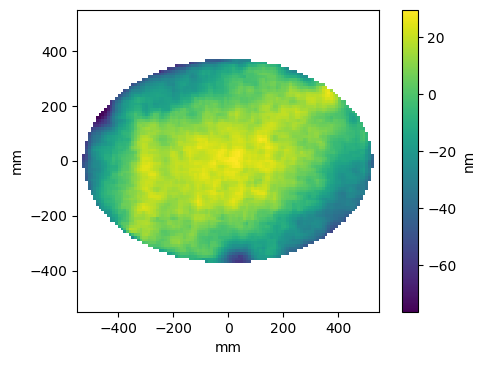

In [2]:
wavelen = 632.8*u.nm
fits_folder = 'zygo_data/Clay/'
m3_data = np.genfromtxt(fits_folder+'Clay_M3_surf.csv', delimiter=',')
np.putmask(m3_data, m3_data==10000, 0)
m3_mask = np.zeros_like(m3_data)
m3_mask = (m3_data!=0).astype(int)
m3_data = (m3_data * wavelen).to(u.micron)

# make mask
m3_active = m3_data[m3_mask==1]
m3_rms = np.sqrt(np.mean(np.square(m3_active)))

# square the matrix
xstart = int((m3_data.shape[0] - m3_data.shape[1])/2)
xend = xstart + m3_data.shape[1]
surf = np.zeros((m3_data.shape[0], m3_data.shape[0]))
surf[:, xstart:xend] = m3_data.value
surf = surf*m3_data.unit
mask = np.zeros((m3_data.shape[0], m3_data.shape[0]))
mask[:, xstart:xend] = m3_mask

# set the scaling
pixscl = ((1*u.cm).to(u.m))/u.pix

# temporarily turn the image
m3_turn = np.transpose(surf.to(u.nm))
mask_turn = np.transpose(mask)

# plot
#dfx.show_image(data=dfx.sn_map((surf.to(u.nm)).value, mask),
dfx.show_image(data=dfx.sn_map(m3_turn.value, mask_turn),
               data_unit=surf.to(u.nm).unit,
               pixscale=(pixscl*u.pix).to(u.mm),
               fig_title=None)
               #fig_title='M3 surface, rms={0:.3f}'.format(m3_rms.to(u.nm)))

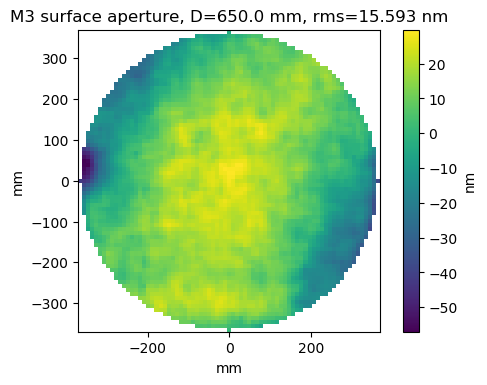

In [3]:
# only choose maximum inner circle region
cen = int(mask.shape[0]/2)
circ_radius = (m3_data.shape[1]-5)/2
yy, xx = np.mgrid[-cen:cen+1, -cen:cen+1]
circ_mask = (yy**2 + xx**2 <= circ_radius**2)
circ_surf = circ_mask * surf

# make the data efficient (remove extraneous zeros)
circ_surf, circ_mask = dfx.mat_tight(data=circ_surf, 
                                     mask=circ_mask, 
                                     print_mat=False)

# calculate the rms
circ_active = circ_surf[circ_mask==1]
circ_rms = np.sqrt(np.mean(np.square(circ_active)))
circ_diam = np.sum(circ_mask[cen]) * pixscl * u.pix

# show data
surf_title = 'M3 surface aperture, D={0}, rms={1:.3f}'.format(circ_diam.to(u.mm),
                                                              circ_rms.to(u.nm))
dfx.show_image(data=dfx.sn_map((circ_surf.to(u.nm)).value, circ_mask),
               data_unit=surf.to(u.nm).unit,
               pixscale=(pixscl*u.pix).to(u.mm),
               fig_title=surf_title)

In [4]:
%%time
opt_parms = {'ca' : 100, # of the 80% CA given
             'ovs': 4096,
             'label': 'M3',
             'surf_units': u.micron,
             'ring_width': 3,
             'kmid_ll': 100/u.m, #0.1/u.mm,
             'khigh_ll': 1000/u.m} #1/u.mm}

# now calculate the PSD
m3 = psd.surfPSD(surf_name='M3')
m3.load_surf(data=circ_surf, wavelen=632e-9*u.m, latres=pixscl)
m3.load_mask(mask=circ_mask)
m3.calc_psd(oversamp=opt_parms['ovs'])
m3.calc_psd_radial(ring_width=opt_parms['ring_width'], kmin=m3.k_min)
m3.calc_rms_set(kmid_ll=opt_parms['kmid_ll'], khigh_ll=opt_parms['khigh_ll'],
                  pwr_opt=m3.psd_cal, print_rms=False, print_kloc=False)

# add in values to opt_parms to make code easier to use
opt_parms['dk'] = m3.delta_k
opt_parms['diam_ca'] = m3.diam_ca
opt_parms['diam_pix'] = m3.npix_diam
opt_parms['wavelen'] = m3.wavelen

CPU times: user 2min 51s, sys: 58.7 s, total: 3min 49s
Wall time: 3min 49s


Text(0.5, 1.0, 'M3 PSD')

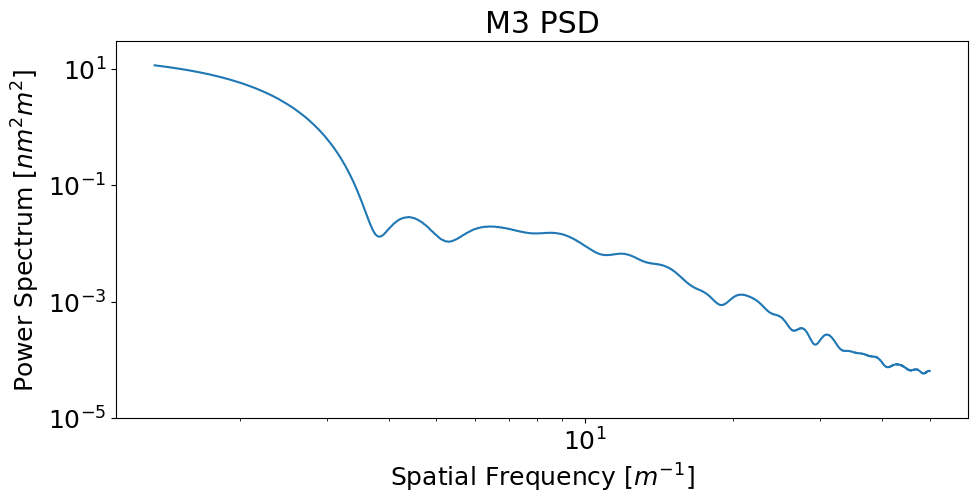

In [5]:
matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[11,5], dpi=100, facecolor='white')
plt.loglog(m3.k_radial.value, m3.psd_radial_cal.value)
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
plt.ylim(top=3e1, bottom=1e-5)
plt.title('M3 PSD')

In [19]:
psd_dict = {'k_radial': m3.k_radial,
            'psd_radial': m3.psd_radial_cal,
            'rms_tot': m3.rms_tot,
            'var': m3.var,
            'diam_ca': m3.diam_ca,
            'npix_diam': m3.npix_diam,
            'oversamp': m3.oversamp,
            'delta_k': m3.delta_k,
            'k_min': m3.k_min,
            'k_max': m3.k_max,
            'ring_width': opt_parms['ring_width']}

psd.psd_radial_to_fits(psd_dict=psd_dict, opt_name=opt_parms['label'],
                       fits_filename='radial/psd_m3.fits')

In [20]:
test = fits.open('radial/psd_m3.fits')
hdr = test[0].header
data = test[1].data
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
OPT_NAME= 'M3      '           / Name of optic                                  
PSD_UNIT= 'm2 nm2  '           / PSD units                                      
RMS_UNIT= 'nm      '           / rms units                                      
VAR_UNIT= 'nm2     '           / variance units                                 
DIAM_CA =                 0.75 / clear aperture diam [m]                        
DIAM_PIX=                   75 / number of pixels in clear aperture             
OVERSAMP=                 4096 / FFT size array after oversampling              
DELTA_K =         0.0244140625 / full psd spatial frequency resolution [1 / m]  
KMIN    =    1.3333333333333

Text(0.5, 1.0, 'M3 PSD')

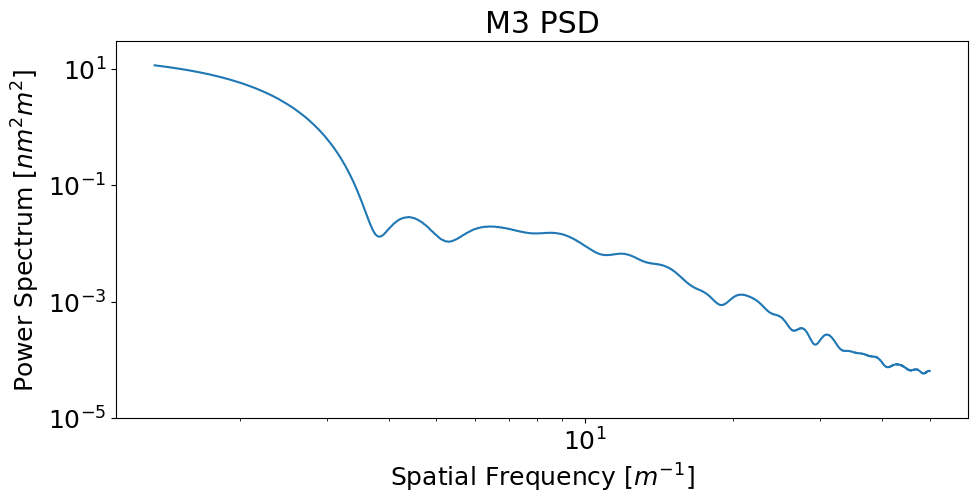

In [21]:
# verify that you can still pull the data out of the FITS table
matplotlib.rcParams["font.size"]=18
plt.figure(figsize=[11,5], dpi=100, facecolor='white')
plt.loglog(data.k_radial, data.psd_radial)
plt.xlabel('Spatial Frequency [{0}]'.format(r'$m^{-1}$'))
plt.ylabel('Power Spectrum [{0}{1}]'.format(r'$nm^{2}$',r'$m^{2}$'))
plt.ylim(top=3e1, bottom=1e-5)
plt.title('M3 PSD')

#### Calculating rms based on beam diameter

In [22]:
opt_parms['rms_tot'] = m3.rms_tot
kmax = m3.k_max
side = m3.psd_cal.shape[0]
dx = 1/(side*opt_parms['dk'])

# make calculations
print('Optic Test: {0}'.format(opt_parms['label']))
print('total paraxial rms: {0:.7f}'.format(opt_parms['rms_tot']))
print('-----')
optic_name = ['M3']
beam_diam = [0.4534555*u.m]
angle = [45*u.deg]
for j in range(0, len(beam_diam)):
    kmin = 1/beam_diam[j]
    print('optic: {0}, beam_diam = {1:.7f}'.format(optic_name[j], beam_diam[j]))
    rms = psd.do_psd_rms(psd_data=m3.psd_cal, delta_k=opt_parms['dk'], k_tgt_lim=[kmin, kmax], 
                         print_rms=False, print_kloc=False)
    angle_rms = rms/np.cos(angle[j]).value
    refl_ang_rms = 2*angle_rms
    print('paraxial rms: {0:.7f}'.format(rms))
    print('angled wfe rms: {0:.7f}'.format(angle_rms))
    print('angled reflected wfe rms (opd): {0:.7f}'.format(refl_ang_rms))
    print('-----')

Optic Test: M3
total paraxial rms: 10.4205366 nm
-----
optic: M3, beam_diam = 0.4534555 m
paraxial rms: 6.1663776 nm
angled wfe rms: 8.7205749 nm
angled reflected wfe rms (opd): 17.4411497 nm
-----
